# Experiments on a new Model

The model here is
$$
\begin{align*}
H(\vec{k})=U(\vec{k})\mathrm{diag}(\epsilon(\vec{k}))U(\vec{k})^{\dagger}
\end{align*}
$$
where $\epsilon(\vec k)$ is fixed by the data and the $U(\vec k)$ can be choosen to reduce high distance terms.

In [1]:
import numpy as np

# Minimize |UXU* - X'|
def minimize(X1, X2):
    # first guess from diagonalization
    la1, ev1 = np.linalg.eigh(X1)
    la2, ev2 = np.linalg.eigh(X2)
    U = ev2 @ ev1.T
    # this seems to always be the best solution...!
    return U

def loss(X1, X2, U):
    return np.linalg.norm(U @ X1 @ np.conj(U.T) - X2)

def reunitarize(U):
    for _ in range(10):
        U = (U + np.linalg.inv(np.conj(U.T))) / 2
    return U

N = 6
X1 = np.random.random((N, N))
X1 = X1 + X1.T
X2 = np.random.random((N, N))
X2 = X2 + X2.T
U = minimize(X1, X2)
print(U)
print(loss(X1, X2, U))
best = loss(X1, X2, U)
for _ in range(1000):
    U_ = U + np.random.standard_normal((N, N)) * 0.001
    U_ = reunitarize(U_)
    #print(U_)
    l = loss(X1, X2, U_)
    if l < best:
        best = l
        U = U_
print(loss(X1, X2, U))

[[ 0.2970017   0.5004972  -0.00132727  0.68356048 -0.17282476 -0.40517583]
 [ 0.8211053  -0.12472039 -0.28666073  0.02646245  0.31255977  0.36008702]
 [-0.07032037 -0.16011436  0.33768293  0.45662355 -0.40718412  0.6936027 ]
 [ 0.28267934 -0.31581837  0.82175135 -0.00966107  0.23289189 -0.30123728]
 [-0.37945969  0.10658673  0.01644767  0.40118504  0.80532138  0.18678094]
 [ 0.09345512  0.77279285  0.35811772 -0.40310913  0.06211216  0.31536353]]
1.2843726226385894
1.2843726226385894


# Exact Model

Turns out there is a simple solution to the Tight-Binding approximation task. For a given $U(\vec k)$ and representation, there is a Tight-Binding Model which exactly reproduces the data. The task becomes to choose a good $U(\vec k)$. This can be done using the solution above to minimize $||UXU^\dagger - X'||_F$

In [2]:
import setup
import numpy as np
from matplotlib import pyplot as plt
import importlib
np.set_printoptions(precision=3, suppress=True)
# finalized libs
import kpaths
from symmetry import *
from unitary_representations import *
from tight_binding import *
UR = UnitaryRepresentation

In [3]:
u_repr = UR.one_dim(False, False, True)

k_smpl = np.array([(0,0,0), (0,0,1), (0,1,1), (1,1,1)])/2
r_smpl = np.array([(0,0,0), (0,0,1), (0,1,1), (1,1,1)])
k_smpl_weights = np.array([1/48, 3/48, 3/48, 1/48]) # how much space each k_smpl represents
R_smpl_weights = np.array([1, 6, 12, 8]) # how often each R appears in the symmetrized form, works for any value, this is just a normalization of the intermediate result.
assert np.all(k_smpl_weights == u_repr.sym.k_weight(k_smpl))
assert np.sum(k_smpl_weights) * len(u_repr.sym) == (3-1)**3
assert np.all(R_smpl_weights == u_repr.sym.r_class_size(r_smpl))
k_smpl = np.array([(0,0,0), (0,0,1), (0,1,1), (1,1,1), (0,0,1/2), (0,1/2,1/2), (1/2,1/2,1/2), (0,1/2,1), (1/2,1/2,1), (1/2,1,1)])/2
r_smpl = np.array([(0,0,0), (0,0,1), (0,1,1), (1,1,1), (0,0,2), (0,2,2), (2,2,2), (0,2,1), (2,2,1), (2,1,1)])
k_smpl_weights = np.array([1/48, 3/48, 3/48, 1/48, 1/8, 1/4, 1/6, 1/4, 1/4, 1/8]) # how much space each k_smpl represents
R_smpl_weights = np.array([1, 6, 12, 8, 6, 12, 8, 24, 24, 24]) # how often each R appears in the symmetrized form, works for any value, this is just a normalization of the intermediate result.
assert np.all(k_smpl_weights == u_repr.sym.k_weight(k_smpl))
assert np.sum(k_smpl_weights) * len(u_repr.sym) == (5-1)**3
assert np.all(R_smpl_weights == u_repr.sym.r_class_size(r_smpl))

In [4]:
# test the fully realized discrete fourier basis for orthogonality
k_smpl_compl, _ = u_repr.sym.realize_symmetric_data(k_smpl, np.zeros_like(k_smpl[:,:1,None]))
r_smpl_compl, _ = u_repr.sym.realize_symmetric_data(r_smpl, np.zeros_like(r_smpl[:,:1,None]))
assert len(k_smpl_compl) == len(r_smpl_compl)
dim = len(k_smpl[0])
n = round(len(k_smpl_compl)**(1/dim))
k_smpl_compl = np.reshape(np.reshape(k_smpl_compl, (n,) * dim + np.shape(k_smpl)[1:])[1:,1:,1:], (-1, dim))
r_smpl_compl = np.reshape(np.reshape(r_smpl_compl, (n,) * dim + np.shape(r_smpl)[1:])[1:,1:,1:], (-1, dim))
V = len(k_smpl_compl)
U = np.exp(2j*np.pi * (k_smpl_compl[:,None,:] * r_smpl_compl[None,:,:]).sum(-1)) / V**.5
#symmetrizer = u_repr.symmetrizer(r_smpl_compl)
#for i in range(len(U)):
#    U[i] = np.reshape(symmetrizer(U[i,:,None,None]), np.shape(U[i]))
#for i in range(len(U)):
#    U[:,i] = np.reshape(symmetrizer(U[:,i,None,None]), np.shape(U[:,i]))
print(np.linalg.eigh(U @ np.conj(U.T))[0])

V = np.sum(k_smpl_weights) * len(u_repr.sym)
a = (k_smpl_weights * len(u_repr.sym))[None,:]
#print(a)
b = R_smpl_weights[None,:]
U = np.exp(2j*np.pi * (k_smpl[:,None,:] * r_smpl[None,:,:]).sum(-1)) * (a/b) / V**.5
print(np.linalg.eigh(U @ np.conj(U.T))[0])
#print(np.abs(U @ np.conj(U.T)) / np.abs(U @ np.conj(U.T))[0,0])
print(np.abs(U))
print(np.abs(np.linalg.inv(U)))
#print(np.abs(np.linalg.inv(np.conj(U.T)) / U))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.    0.001 0.003 0.007 0.012 0.044 0.078 0.137 0.152 0.331]
[[0.125 0.062 0.031 0.016 0.125 0.125 0.125 0.062 0.062 0.031]
 [0.125 0.062 0.031 0.016 0.125 0.125 0.125 0.062 0.062 0.031]
 [0.125 0.062 0.031 0.016 0.125 0.125 0.125 0.062 0.062 0.031]
 [0.125 0.062 0.031 0.016 0.125 0.125 0.125 0.062 0.062 0.031]
 [0.125 0.062 0.031 0.016 0.125 0.125 0.125 0.062 0.062 0.031]
 [0.125 0.062 0.031 0.016 0.125 0.125 0.125 0.062 0.062 0.031]
 [0.125 0.062 0.031 0.016 0.125 0.125 0.125 0.062 0.062 0.031]
 [0.125 0.062 0.031 0.016 0.125 0.125 0.125 0.062 0.062 0.031]
 [0.125 0.062 0.031 0.016 0.125 0.125 0.125 0.062 0.062 0.031]
 [0.125 0.062 0.031 0.016 0.125 0.125 0.125 0.062 0.062 0.031]]
[[ 2.828  2.828  0.     0.     4.     0.     0.     0.     0.     0.   ]
 [ 8.     8.     5.657  0.     5.657  

In [5]:
k_smpl = np.array([-1/4, 0, 1/4, 1/2])
r_smpl = np.array([-1, 0, 1, 2])

V = 4
U = np.exp(2j*np.pi * (k_smpl[:,None] * r_smpl[None,:])) / V**.5
print(np.linalg.eigh(U @ np.conj(U.T))[0])
print(U @ np.conj(U.T))

[1. 1. 1. 1.]
[[ 1.+0.j  0.-0.j  0.+0.j -0.-0.j]
 [ 0.+0.j  1.+0.j  0.-0.j  0.+0.j]
 [ 0.-0.j  0.+0.j  1.+0.j  0.-0.j]
 [-0.+0.j  0.-0.j  0.+0.j  1.+0.j]]


In [6]:
def random_matrices(u_repr, k_smpl):
    H_mat = np.array([np.random.standard_normal((u_repr.dim(),)*2) + 1j*np.random.standard_normal((u_repr.dim(),)*2) for _ in range(len(k_smpl))])
    H_mat = u_repr.symmetrize2(k_smpl, H_mat)
    if u_repr.sym.inversion:
        # one symmetry has not yet been applied by symmetrize2, because it doesn't know about it
        # I H_r I = H_r^+
        H_mat_neg = np.array(H_mat)
        k = u_repr.inv_split
        H_mat_neg[:,:k,k:] *= -1
        H_mat_neg[:,k:,:k] *= -1
        H_mat = (H_mat + np.conj(np.swapaxes(H_mat_neg, -1, -2))) / 2
    assert np.linalg.norm(H_mat - u_repr.symmetrize2(k_smpl, H_mat)) < 1e-13
    A_mat = H_mat + np.conj(np.swapaxes(H_mat, -1, -2))
    B_mat = -1j*(H_mat - np.conj(np.swapaxes(H_mat, -1, -2)))
    return H_mat, A_mat, B_mat

def r_smpl_from_k_smpl(k_smpl):
    # this only works for grids... (can be symmetry reduced)
    n = np.linalg.norm(k_smpl, axis=-1)
    scale = 1 / np.min(n[n > 0])
    return k_smpl * scale

In [7]:
#u_repr = UR.one_dim(False, False, True) + UR.one_dim(True, True, True)
#u_repr = UR.d3(False)
u_repr = UR.one_dim(False, False, True) + UR.one_dim(True, True, True) + UR.d3(False) + UR.o3()
#u_repr = UR.one_dim(False, False, False) + UR.one_dim(True, False, False)
#u_repr = UR.d3(False, False)
k_smpl = np.array([(0,0,0), (0,0,1), (0,1,1), (1,1,1), (0,0,1/2), (0,1/2,1/2), (1/2,1/2,1/2), (0,1/2,1), (1/2,1/2,1), (1/2,1,1)])/2
r_smpl = r_smpl_from_k_smpl(k_smpl)
k_smpl_weights = u_repr.sym.k_weight(k_smpl)
R_smpl_weights = u_repr.sym.r_class_size(r_smpl)
H_r, A_r, B_r = random_matrices(u_repr, k_smpl)

# discrete fourier transform with symmetry (with inversion symmetry, or with a set of k_smpl, which also includes -k_smpl)
def idft_sym(u_repr, k_smpl, R_smpl_weights, H_r, R_smpl):
    H_k = np.zeros_like(H_r)
    for sign in [-1, 1] if u_repr.sym.inversion else [1]:
        if sign == 1:
            k = u_repr.inv_split
            H_k[:,:k,k:] *= -1
            H_k[:,k:,:k] *= -1
            # adjungation doesn't change anything as H_k is hermitian
            #assert np.linalg.norm(np.conj(np.swapaxes(H_k, -1, -2)) - H_k) < 1e-7
        for s, u in zip(u_repr.sym.S, u_repr.U):
            w = np.exp(-sign * 2j*np.pi * np.einsum("ij,nj,mi->mn", s, k_smpl, R_smpl))[...,None,None]
            H_k += np.sum(np.einsum("n,nij,il,jm->nlm", R_smpl_weights, H_r, np.conj(u), u)[:,None,...] * w, axis=0)
    assert np.linalg.norm(np.conj(np.swapaxes(H_k, -1, -2)) - H_k) < 1e-7
    return H_k / len(u_repr.sym)

def idft_sym2(u_repr, k_smpl, R_smpl_weights, A_r, B_r, R_smpl):
    H_k = np.zeros_like(A_r)
    k = u_repr.inv_split
    for s, u in zip(u_repr.sym.S, u_repr.U):
        t = 2*np.pi * (np.einsum("ij,nj->ni", s, k_smpl)[None,:,:] * R_smpl[:,None,:]).sum(-1)
        wc = np.cos(t)[...,None,None]
        ws = np.sin(t)[...,None,None]
        A_add = np.sum(np.einsum("n,nij,il,jm->nlm", R_smpl_weights, A_r, np.conj(u), u)[:,None,...] * wc, axis=0)
        B_add = np.sum(np.einsum("n,nij,il,jm->nlm", R_smpl_weights, B_r, np.conj(u), u)[:,None,...] * ws, axis=0)
        H_k = H_k + A_add + B_add
        if u_repr.sym.inversion:
            a = A_add - B_add # from the symmetry of A_-r and B_-r
            a[:,:k,k:] *= -1 # from the sin sign
            a[:,k:,:k] *= -1
            H_k += a
    return H_k / len(u_repr.sym) / 2


H_k = idft_sym(u_repr, k_smpl, R_smpl_weights, H_r, r_smpl)
H2_k = idft_sym2(u_repr, k_smpl, R_smpl_weights, A_r, B_r, r_smpl)
print(np.linalg.norm(H_k - H2_k)) # these two align and are therefore maybe correct
print(np.linalg.norm(H_k - H2_k, axis=(-1,-2)))
#print(np.abs(H_r[:,1,0]))
print(np.abs(H_k[:,1,0]))
print(np.abs(H2_k[:,1,0]))
#print((H_k - H2_k)[:,1,0])
assert np.linalg.norm(H_k - H2_k) < 1e-13

7.313507927016438e-14
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 0.    21.44   0.     0.     0.339  0.     0.     8.023  5.64   0.   ]
[ 0.    21.44   0.     0.     0.339  0.     0.     8.023  5.64   0.   ]


In [8]:
u_repr = UR.one_dim(False, False, True)# + UR.one_dim(False, False, True)
#u_repr = UR.d3(False)
k_smpl = np.array([(0,0,0), (0,0,1), (0,1,1), (1,1,1)])#, (0,0,1/2), (0,1/2,1/2), (1/2,1/2,1/2), (0,1/2,1), (1/2,1/2,1), (1/2,1,1)])/2
r_smpl = r_smpl_from_k_smpl(k_smpl)
k_smpl_weights = u_repr.sym.k_weight(k_smpl)
R_smpl_weights = u_repr.sym.r_class_size(r_smpl)
H_mat, A_mat, B_mat = random_matrices(u_repr, k_smpl)

# mostly for testing purposes
def fft_sym(u_repr: UnitaryRepresentation, k_smpl, k_per_R_smpl_weights, data):
    dim = len(k_smpl[0])
    k_smpl_compl, data_compl = u_repr.realize_symmetric_matrices(k_smpl, data, inverse=True) # inverse matrices?
    n = round(len(data_compl)**(1/dim))
    data_compl = np.reshape(data_compl, (n,) * dim + np.shape(data)[1:])[1:,1:,1:]
    k_smpl_compl = np.reshape(k_smpl_compl, (n,) * dim + np.shape(k_smpl)[1:])[1:,1:,1:]
    #print(data_compl)
    fft_data = np.fft.ifftn(data_compl, axes=(0,1,2))
    #fft_data = np.fft.fftshift(fft_data, (0,1,2))
    #fft_data = np.roll(fft_data, -n//2, axis=(0,1,2))
    #print(fft_data[...,0,0])
    fft_data = np.reshape(fft_data, (-1,) + np.shape(data)[1:])
    # reduce the data back to k_smpl
    indices = [next((i for i, k_ in enumerate(k_smpl_compl.reshape(-1, dim)) if np.linalg.norm(k_ - k) < 1e-7)) for k in k_smpl]
    return fft_data[indices] * k_per_R_smpl_weights[:,None,None] * len(u_repr.sym)

def ifft_sym(u_repr: UnitaryRepresentation, k_smpl, k_per_R_smpl_weights, data):
    dim = len(k_smpl[0])
    #mul = 1 / (k_per_R_smpl_weights[:,None,None] * len(u_repr.sym))
    #print(mul) # experiment with this multiplier...
    k_smpl_compl, data_compl = u_repr.realize_symmetric_matrices(k_smpl, data * mul, inverse=False)
    n = round(len(data_compl)**(1/dim))
    data_compl = np.reshape(data_compl, (n,) * dim + np.shape(data)[1:])[1:,1:,1:]
    k_smpl_compl = np.reshape(k_smpl_compl, (n,) * dim + np.shape(k_smpl)[1:])[1:,1:,1:]
    #print(data_compl)
    fft_data = np.fft.fftn(data_compl, axes=(0,1,2))
    #fft_data = np.roll(fft_data, 1, axis=(0,1,2))
    #print(fft_data)
    fft_data = np.reshape(fft_data, (-1,) + np.shape(data)[1:])
    # reduce the data back to k_smpl
    indices = [next((i for i, k_ in enumerate(k_smpl_compl.reshape(-1, dim)) if np.linalg.norm(k_ - k) < 1e-7)) for k in k_smpl]
    return fft_data[indices] * mul2

# experiment with mul and mul2, as things don't line up...
mul = best_mul = np.array([1, 1, 1, 1])[:,None,None]
mul2 = best_mul2 = np.array([1, 1, 1, 1])[:,None,None]
A = ifft_sym(u_repr, k_smpl, k_smpl_weights / R_smpl_weights, H_mat)
B = idft_sym(u_repr, k_smpl, R_smpl_weights, H_mat, r_smpl)
best = np.linalg.norm(A - B)
print(best)
for _ in range(100):
    mul = best_mul * (0.9 + np.random.random(np.shape(mul)) * 0.2)
    mul2 = best_mul2 * (0.9 + np.random.random(np.shape(mul)) * 0.2)
    A = ifft_sym(u_repr, k_smpl, k_smpl_weights / R_smpl_weights, H_mat)
    B = idft_sym(u_repr, k_smpl, R_smpl_weights, H_mat, r_smpl)
    score = np.linalg.norm(A - B)
    if score < best:
        best_mul = mul
        best_mul2 = mul2
        best = score
print(repr(np.ravel(best_mul)))
print(repr(np.ravel(best_mul2)))
print(best)
#print((A / B)[:,0,0])

H2_k = fft_sym(u_repr, k_smpl, k_smpl_weights / R_smpl_weights, A)
print(np.linalg.norm(H_mat - H2_k)) # this works!

21.302842596473454
array([0.439, 0.417, 0.927, 0.688])
array([4.739, 1.899, 0.657, 0.587])
18.222756823920918
1.6551605029956389


In [9]:
# discrete fourier transform with symmetry (with inversion!!! without inversion it would need to decompose into A_r, B_r)
# NOTE: this one does not require a grid, but it requires correct integration weights k_smpl_weights
def dft_sym(u_repr, k_smpl, k_smpl_weights, R_smpl_weights, H_k, R_smpl):
    H_r = np.zeros_like(H_k)
    weight = np.sum(k_smpl_weights)
    for sign in [-1, 1] if u_repr.sym.inversion else [1]:
        if sign == 1:
            k = u_repr.inv_split
            H_r[:,:k,k:] *= -1
            H_r[:,k:,:k] *= -1
            #H_r = np.conj(np.swapaxes(H_r, -1, -2)) # seems to do the same as I.I
        for s, u in zip(u_repr.sym.S, u_repr.U):
            w = np.exp(sign * 2j*np.pi * np.einsum("ij,nj,mi->mn", s, k_smpl, R_smpl))[...,None,None]
            H_r = H_r + np.sum(np.einsum("n,nij,li,mj->nlm", k_smpl_weights, H_k, u, np.conj(u))[None,:,...] * w, axis=1) / weight
    # TODO investigate why this R_weight "mul" is so weird...
    # -> probably the k_smpl and R_smpl don't fit together
    #V = weight * len(u_repr.sym)
    #n = round(V**(1/3)) // 2 * 2
    #mul = (u_repr.sym.k_weight(r_smpl / n) * len(u_repr.sym)) / R_smpl_weights
    mul = k_smpl_weights * len(u_repr.sym) / R_smpl_weights # this works for correctly sorted r_smpl
    return H_r / len(u_repr.sym) * mul[:,None,None]

#u_repr = UR.one_dim(False, False, True) + UR.one_dim(True, True, True)
#u_repr = UR.d3(False)
u_repr = UR.one_dim(False, False, True) + UR.one_dim(True, True, True) + UR.d3(False) + UR.o3()
if False:
    k_smpl = np.array([(0,0,0), (0,0,1), (0,1,1), (1,1,1)])/2
else:
    k_smpl = np.array([(0,0,0), (0,0,1), (0,1,1), (1,1,1), (0,0,1/2), (0,1/2,1/2), (1/2,1/2,1/2), (0,1/2,1), (1/2,1/2,1), (1/2,1,1)])/2
r_smpl = r_smpl_from_k_smpl(k_smpl) # with this I can actually use k_weight above
k_smpl_weights = u_repr.sym.k_weight(k_smpl)
R_smpl_weights = u_repr.sym.r_class_size(r_smpl)
#print(k_smpl_weights * len(u_repr.sym))
#print(R_smpl_weights)
#print(R_smpl_weights / (k_smpl_weights * len(u_repr.sym)))
#print(R_smpl_weights / (u_repr.sym.k_weight(r_smpl / 4) * len(u_repr.sym)))
#H_mat = np.array([((27,),), ((-15,),), ((7,),), ((-3,),)])
#H_mat = np.array([((1,),), ((2,),), ((3,),), ((4,),)])
H_r, _, _ = random_matrices(u_repr, k_smpl)
H_k = idft_sym(u_repr, k_smpl, R_smpl_weights, H_r, r_smpl) # known to work!
#print(k_smpl_weights / R_smpl_weights * 48 * 2)
#fft = fft_sym(u_repr, k_smpl, k_smpl_weights / R_smpl_weights, H_k)
#print(fft)
dft = dft_sym(u_repr, k_smpl, k_smpl_weights, R_smpl_weights, H_k, r_smpl)
#print(np.linalg.norm(fft - dft))
#print(np.abs(fft/dft)[:,0,0])
print(np.linalg.norm(H_r - dft))
print("idft_sym projection:", np.linalg.norm(H_k - idft_sym(u_repr, k_smpl, R_smpl_weights, dft, r_smpl)))
print("dft_sym  projection:", np.linalg.norm(dft - dft_sym(u_repr, k_smpl, k_smpl_weights, R_smpl_weights, idft_sym(u_repr, k_smpl, R_smpl_weights, dft, r_smpl), r_smpl)))
print(np.abs(dft - H_r)[:,0,0])
#print(np.abs(H_k)[:,1,0])
print(np.abs(dft)[:,1,0])
print(np.abs(H_r)[:,1,0])
#print(np.real(H_r)[:,0,1])

7.329599215876545
idft_sym projection: 1.4073780535817958e-13
dft_sym  projection: 8.007288758307711e-15
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.    0.742 0.    0.    0.147 0.    0.    1.594 0.01  0.   ]
[0.    0.742 0.    0.    0.147 0.    0.    1.594 0.01  0.   ]


So appearantly the FFT version is invertible, but fundametally different from the DFT version for unexplained reasons... Also the DFT version seems to be a projection that looses some information that should have been preserved... specifically the `idft_sym`. So I guess the $H_k$ just have more structure than I did expect, not sure what's missing...

If a given bandstructure can be turned into a fourier series and back with a given set of symmetries, then the bandstructure agrees with the symmetry. If it can't be recovered, it doesn't agree with the symmetry. -> test how flexible the unitary representation is, is ordering an issue?

In [10]:
u_repr_test = UR.one_dim(False, True, True) + UR.d3(False)

u_repr = u_repr_test # this doesn't work yet...
#u_repr = UR.one_dim(False, False, True) + UR.d3(True) # doesn't work
#u_repr = UR.one_dim(False, True, True) + UR.one_dim(False, False, True)*2
#u_repr = UR.one_dim(False, False, True) + UR.one_dim(False, True, True)*2
#u_repr = UR.o3() # doesn't work
#u_repr = UR.one_dim(False, False, True)*3 # can represent anything

print("difference:", np.linalg.norm(u_repr_test.U - u_repr.U), u_repr_test.inv_split - u_repr.inv_split)

assert u_repr_test.dim() == u_repr.dim()
tb_test = TightBindingModel(u_repr_test, neighbors, np.random.random((len(neighbors),)+(u_repr_test.dim(),)*2))
tb_test.normalize()
ref_bands = tb_test(k_smpl)
#ref_bands = np.sort(ref_bands, axis=-1)
print(ref_bands[0])

def unique_tol(arr, tol=1e-7):
    order = np.argsort(arr)
    arr = arr[order]
    last = arr[0]
    counts = [1]
    indices = [[order[0]]]
    for j in range(1, len(arr)):
        if abs(arr[j] - last) > tol:
            last = arr[j]
            counts.append(1)
            indices.append([order[j]])
        else:
            counts[-1] += 1
            indices[-1].append(order[j])
    return indices, counts

# preprocess the ref_bands to be sorted to match u_repr
for i in range(len(ref_bands)):
    subspaces, counts = u_repr.subspaces() # TODO move out and just copy here
    permutation = np.arange(u_repr.dim())
    band = ref_bands[i]
    indices, _ = unique_tol(band, 1e-5)
    # better than the following:
    #bands, inverse, degeneracy = np.unique(np.round(ref_bands[i], 4), return_inverse=True, return_counts=True)
    #print(degeneracy)
    indices = sorted(indices, key=lambda x: -len(x)) # stable sort
    # arrange the values to the groups
    # no grouped eigenvalue can be divided into multiple subspaces
    # except if there are none of the right size left. (but then the representation is incorrect)
    for group in indices:
        # this groups can not be divided,
        # so find a subspace that is larger or equal than this group
        index = np.argmax(counts) # since we are processing the largest remaining group, put it into the largest remaining space
        subspace = subspaces[index]
        #print(subspace, group)
        if counts[index] > len(group):
            # only partially use up the subspace
            rem = len(group)
            rem_subspace = subspace
            for j in range(len(subspace)):
                if rem == 0:
                    rem_subspace = subspace.copy()
                    rem_subspace[:j] = False
                    subspace[j:] = False
                    break
                if subspace[j]:
                    rem -= 1
            subspaces[index] = rem_subspace
            counts[index] -= len(group)
        else:
            assert counts[index] >= len(group), "not enough symmetry in the model, the reference has more symmetry"
            subspaces = np.delete(subspaces, index, axis=0)
            counts = np.delete(counts, index)
        permutation[subspace] = group
    assert len(np.unique(permutation)) == len(permutation), f"permutation was {permutation}"
    #print(permutation)
    ref_bands[i] = ref_bands[i][permutation]
    print(unique_tol(ref_bands[i], 1e-5)[0])
# this isn't enough...

H_k = np.einsum("ni,ij->nij", ref_bands, np.eye(u_repr.dim()))
H_r = dft_sym(u_repr, k_smpl, k_smpl_weights, R_smpl_weights, H_k, r_smpl)
H_k_check = idft_sym(u_repr, k_smpl, R_smpl_weights, H_r, r_smpl)
print("dft done")
error = np.linalg.norm(np.linalg.eigvalsh(H_k_check) - np.sort(ref_bands, axis=1))
print(np.linalg.norm(np.linalg.eigvalsh(H_k_check) - np.sort(ref_bands, axis=1), axis=-1))
print(np.linalg.eigvalsh(H_k_check[1]))
print(np.sort(ref_bands[1]))
#error = np.linalg.norm(H_k_check - H_k)
assert error < 1e-7, f"error was {error}, the symmetry can't represent the data"
print("check done")

difference: 0.0 0
[0.606 0.606 0.644]
[[0, 1], [2]]
[[0], [2], [1]]
[[0], [2], [1]]
[[0, 1], [2]]
[[0], [2], [1]]
[[0], [2], [1]]
[[0, 1], [2]]
[[0], [2], [1]]
[[0], [2], [1]]
[[0], [2], [1]]
dft done
[0.    0.859 0.    0.    0.858 0.    0.    0.    0.987 0.   ]
[-10.917 -10.508  -9.703]
[-11.525 -10.508  -9.095]


AssertionError: error was 1.564288312032315, the symmetry can't represent the data

In [35]:
import qespresso_interface as qe
material = qe.QECrystal("nitinol_0K", [], [], [], 0)
k_smpl, ref_weights, ref_bands, symmetries, fermi_energy = material.read_bands()
# sort k_smpl by distance
order = np.argsort(np.linalg.norm(k_smpl, axis=-1))
k_smpl = k_smpl[order]
ref_bands = ref_bands[order]

ref_weights = ref_weights[order]
u_repr = UR.one_dim(False, False, True)*12
assert np.linalg.norm(ref_weights * 20**3 / 2 - u_repr.sym.k_weight(k_smpl) * 48) < 1e-7

# reduce the amount of data to a 10x10x10 grid
sym = Symmetry.cubic(True)
k_smpl, ref_bands = sym.realize_symmetric_data(k_smpl, ref_bands)
k_smpl = k_smpl.reshape(21, 21, 21, 3)[::2,::2,::2].reshape(-1, 3)
ref_bands = ref_bands.reshape(21, 21, 21, -1)[::2,::2,::2].reshape(-1, len(ref_bands[0]))
k_smpl, ref_bands = sym.reduce_symmetric_data(k_smpl, ref_bands)

all_ref_bands = ref_bands
ref_bands = ref_bands[:,8:]

In [ ]:
# toy data for experimentation
# TODO

In [28]:
#u_repr = UR.one_dim(False, False, True) + UR.d3(False) + UR.so3() + UR.d3(False) + UR.so3() + UR.o3()
#u_repr = UR.one_dim(False, False, True) + UR.d3(False) + UR.so3() + UR.d3(False) + UR.so3() + UR.one_dim(False, True, True)
u_repr = UR.one_dim(False, False, True)*12
band_offset = 0 # = additional bands below reference

k_smpl_weights = u_repr.sym.k_weight(k_smpl)

# get the r_smpl from the k_smpl
r_smpl = r_smpl_from_k_smpl(k_smpl)
R_smpl_weights = u_repr.sym.r_class_size(r_smpl)

# get the laplacian on the periodic reciprocal (k) lattice
def get_laplacian(k_smpl):
    laplace = np.zeros((len(k_smpl),)*2) # huge matrix
    min_dist = np.min(np.linalg.norm(k_smpl[1:], axis=-1)) * 1.001
    for i, k1 in enumerate(k_smpl):
        for j, k2 in enumerate(k_smpl[i+1:]):
            if np.linalg.norm(k1 - k2) <= min_dist: # TODO missing symmetries!
                laplace[i, j] += 1
                laplace[j, i] += 1
                laplace[i, i] -= 1
                laplace[j, j] -= 1
    return laplace / np.trace(laplace) * len(k_smpl)

laplacian = get_laplacian(k_smpl)
#laplacian = laplacian @ laplacian # 2x laplacian
#laplacian = laplacian @ laplacian # 4x laplacian

# smooth with a precalculated laplacian
def smooth(laplacian, mat_k, strength):
    return mat_k + np.einsum("ij,j...->i...", laplacian, mat_k) * strength

# Minimize |UXU* - X'|
def minimize(X1, X2):
    # first guess from diagonalization
    _, ev1 = np.linalg.eigh(X1)
    _, ev2 = np.linalg.eigh(X2)
    U = ev2 @ np.conj(np.swapaxes(ev1, -1, -2))
    # this seems to always be the best solution...!
    return U # always unitary!

def reunitarize(U):
    for _ in range(30):
        U = (U + np.linalg.inv(np.conj(np.swapaxes(U, -1, -2)))) / 2
    return U

# now start my algorithm to find good matrices
if True:
    n = len(ref_bands[0])
    U = np.zeros((len(ref_bands), n, n))
    U += np.eye(n)[None,:,:]
    # first randomize a tiny bit to break subspaces
    U = U + np.random.standard_normal(np.shape(U)) * 0.2 + np.random.standard_normal(np.shape(U)) * 0.2j
    U = smooth(laplacian, U, 1)
    U = smooth(laplacian, U, 1)
    U = u_repr.symmetrize2(k_smpl, U)
    U = reunitarize(U)

In [29]:
assert np.linalg.norm(U @ np.conj(np.swapaxes(U, -1, -2)) - np.eye(n)[None,:,:]) < 1e-7, "U matrices not unitary"
select = np.linalg.norm(r_smpl, axis=-1) > 3
start_i = next((i for i, s in enumerate(select) if s))
U = reunitarize(U)
for m in range(100):
    # each iteration is a full sweep through all k_smpl U matrices
    #i = start_i
    #for i in range(start_i, min(2*start_i, len(k_smpl)), 1):
    if True:
        H_k = np.einsum("nli,ni,nmi->nlm", U, ref_bands, np.conj(U))
        assert np.linalg.norm(np.conj(np.swapaxes(H_k, -1, -2)) - H_k) < 1e-7, "H_k is non hermitian"
        H_r = dft_sym(u_repr, k_smpl, k_smpl_weights, R_smpl_weights, H_k, r_smpl)
        #print(np.linalg.norm(H_r, axis=(-1, -2)))
        print(np.sqrt(np.sum(np.linalg.norm(H_r, axis=(-1, -2))[select]**2)))
        H_r[select] = 0.0
        new_H_k = idft_sym(u_repr, k_smpl, R_smpl_weights, H_r, r_smpl)
        #dU = minimize(H_k, new_H_k)
        #U = dU @ U
        U_ = np.linalg.eigh(new_H_k)[1] # equivalent to above
        if m % 10 == 0:
            U_ = smooth(laplacian, U_, 0.01)
        # a new symmetrization is appearantly not needed...
        U_ = u_repr.symmetrize2(k_smpl, U_)
        #U_ += np.random.standard_normal(np.shape(U_)) * 0.001
        U_ = reunitarize(U_ + np.eye(n)[None,:,:] * 0.0001)
        #print(np.linalg.norm(U - U_))
        U = U_

1.7515660547437828
0.5157779525820527


KeyboardInterrupt: 

In [33]:
print("using", len(ref_bands[0]), " data bands")
print("using", len(u_repr.U[0]), " model bands")

assert np.linalg.norm(U @ np.conj(np.swapaxes(U, -1, -2)) - np.eye(n)[None,:,:]) < 1e-7, "U matrices not unitary"

H_k = np.einsum("nli,ni,nmi->nlm", U, ref_bands, np.conj(U))
assert np.linalg.norm(np.linalg.eigvalsh(H_k) - ref_bands) < 1e-7
#H_k = np.einsum("ni,ij->nij", ref_bands, np.eye(u_repr.dim()))
H_r = dft_sym(u_repr, k_smpl, k_smpl_weights, R_smpl_weights, H_k, r_smpl)
H_k_check = idft_sym(u_repr, k_smpl, R_smpl_weights, H_r, r_smpl)
print("dft done")
error = np.linalg.norm(H_k_check - H_k)
assert error < 1e-7, f"error was {error}, the symmetry can't represent the data"
print("check done")

H_r[start_i:] = 0.0 # set the error terms to 0
H_k_check = idft_sym(u_repr, k_smpl, R_smpl_weights, H_r, r_smpl)

using 12  data bands
using 12  model bands
dft done
check done


realized
unique band energies: 6
irreducible symmetry sizes (data):  {1: 2, 2: 2, 3: 2}
irreducible symmetry sizes (model): {1: 12, 2: 0, 3: 0}
model built


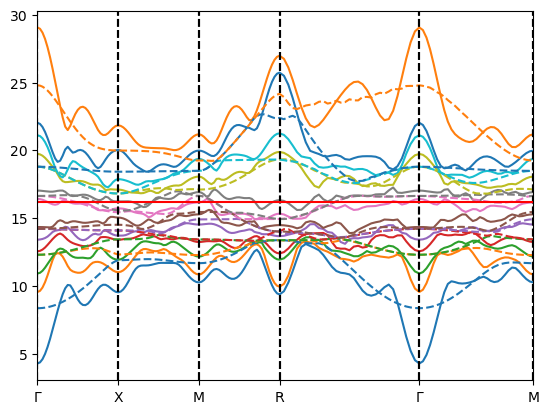

In [34]:
A_r = H_r + np.conj(np.swapaxes(H_r, -1, -2))
B_r = -1j*(H_r - np.conj(np.swapaxes(H_r, -1, -2)))
C_r = A_r + B_r
# correct cos terms to be cos-1
k = u_repr.inv_split
C_r_ = u_repr.symmetrize2(r_smpl, C_r)
assert np.linalg.norm(C_r_ - C_r) < 1e-7, "symmetrization should be irrelevant here..."
C_r = C_r_
neighbors, C_r_compl = u_repr.realize_symmetric_matrices(r_smpl, C_r, sorted=False, inverse=True)
C_r_compl[0,:k,:k] += np.sum(C_r_compl[1:,:k,:k], axis=0)
C_r_compl[0,k:,k:] += np.sum(C_r_compl[1:,k:,k:], axis=0)
C_r_compl[0] *= 0.5
keep_indices = [i for i, n in enumerate(neighbors) if n[0] > 0 or (n[0] == 0 and (n[1] > 0 or (n[1] == 0 and n[2] >= 0)))]
neighbors = neighbors[keep_indices]
C_r_compl = C_r_compl[keep_indices]
# sort by magnitude
print("realized")

#if "tb_nitinol" not in locals():
tb_nitinol = TightBindingModel.init_from_ref(u_repr, neighbors, k_smpl, ref_bands, use_repr_order=False, verbose=True)
assert np.shape(tb_nitinol.params) == np.shape(C_r_compl)
tb_nitinol.params = C_r_compl
#tb_nitinol.normalize()
assert u_repr.check_symmetry(tb_nitinol.f)
print("model built")

error = np.linalg.norm(tb_nitinol.f(k_smpl) - H_k_check)
assert error < 1e-7, f"tight binding model produces different result from idft with error {error}"

path = kpaths.KPath('G').to('X').to('M').to('R').to('G').to('M')
interpolator = kpaths.interpolate(k_smpl, ref_bands, Symmetry.cubic(True), method='cubic')
path.plot(tb_nitinol, '-')
path.plot(interpolator, '--')
plt.axhline(fermi_energy, color="r")
plt.show()

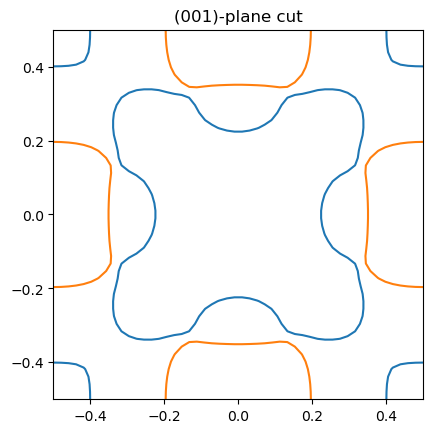

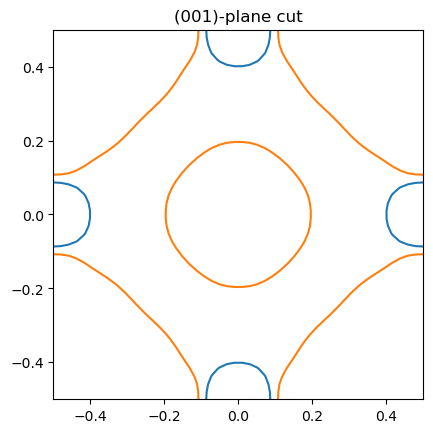

In [ ]:
import fermi_surface as fs
# 2d fermi surface cuts
fs.plot_2D_fermi_surface(tb_nitinol, fermi_energy, N=50)

Turns out the $U_S$ can depend on $\vec{k}$. Try to do a Fourier transform of $U_SXU_S^\dagger$ as a 4-Tensor and check what Form the terms have.

In [192]:
# take a unitary matrix function
def U(k):
    k = np.asarray(k)
    #basis = np.eye(2)[None,...]
    basis = np.array([[np.cos(k), np.sin(k)], [-np.sin(k), np.cos(k)]]).T
    zero = np.zeros_like(k)
    one = np.ones_like(k)
    u = np.array([[one, zero], [zero, np.exp(2j * k)]]).T
    u = basis @ u @ np.swapaxes(basis, -1, -2)
    return u

def U2(k):
    k = np.asarray(k)
    res1 = np.zeros((len(k), 3, 3), dtype=np.complex128)
    res1[:] = np.eye(3)
    res1[:,:2,:2] = U(k)
    res2 = np.zeros((len(k), 3, 3), dtype=np.complex128)
    res2[:] = np.eye(3)
    res2[:,1:,1:] = U(k+np.pi)
    return res1 @ res2

#print(U2([0.0]))
#print(U2([np.pi/2]))
#print(U2([np.pi]))
#print(U2([np.pi*2]))

k_smpl = np.linspace(0, 2*np.pi, 8, endpoint=False)
Uk = U(k_smpl)
n = len(Uk[0])
assert np.linalg.norm(Uk @ np.swapaxes(np.conj(Uk), -1, -2) - np.eye(n)) <= 1e-7, "Uk not unitary"

Ur = np.reshape(np.fft.ifft(np.reshape(Uk, (-1, n*n)), axis=0), (-1, n, n))

Tk = np.einsum("pij,pnk->pijkn", Uk, np.conj(Uk))
Tr = np.reshape(np.fft.ifft(np.reshape(Tk, (-1, n*n*n*n)), axis=0), (-1, n, n, n, n))
A = np.sum(Tr, axis=(3, 4))
B = np.sum(Tr, axis=(1, 2))
Tr2 = np.einsum("pij,pkn->pijkn", A, B)
for i in range(len(Tr)):
    fac = np.mean(Tr[i][np.abs(Tr2[i]) > 1e-7] / Tr2[i][np.abs(Tr2[i]) > 1e-7])
    if not np.isnan(fac):
        Tr2[i] *= fac
        #print(fac)
#print("     ", np.linalg.norm(np.linalg.norm(Tr, axis=(-1,-2)), axis=(-1,-2)))
#print("error", np.linalg.norm(np.linalg.norm(Tr - Tr2, axis=(-1,-2)), axis=(-1,-2)))
#U0 = np.sum(Ur, axis=0)
#print(U0)
#print(np.abs(np.linalg.det(U0)))
#N = len(k_smpl)
#Uk2 = (np.exp(-2j*np.pi/N*np.arange(N)[None,:]*np.arange(N)[:,None])[:,:,None,None] * Ur[:,None,:,:]).sum(0)
#print(np.abs(np.linalg.det(Uk2)), "Uk2")
#U0 = np.fft.fft(np.reshape(Ur, (-1, n*n))).reshape(-1, n, n)[0]

#assert np.linalg.norm(U0 @ np.conj(U0).T - np.eye(n)) < 1e-7
#print(np.linalg.norm(Ur @ np.swapaxes(np.conj(Ur), -1, -2) - np.eye(n), axis=(-1,-2)))
#print(Tr)
print(Ur)

[[[ 0.25-0.j   -0.  -0.25j]
  [-0.  -0.25j  0.75+0.j  ]]

 [[-0.  -0.j   -0.  -0.j  ]
  [-0.  -0.j    0.  +0.j  ]]

 [[ 0.25+0.j   -0.  +0.25j]
  [-0.  +0.25j -0.25-0.j  ]]

 [[-0.  +0.j    0.  +0.j  ]
  [ 0.  +0.j    0.  +0.j  ]]

 [[-0.25+0.j    0.  +0.25j]
  [ 0.  +0.25j  0.25-0.j  ]]

 [[ 0.  +0.j    0.  -0.j  ]
  [ 0.  -0.j   -0.  +0.j  ]]

 [[ 0.75-0.j   -0.  -0.25j]
  [-0.  -0.25j  0.25-0.j  ]]

 [[-0.  -0.j    0.  +0.j  ]
  [ 0.  +0.j   -0.  +0.j  ]]]
